# Data Analysis - Velib Project in [Python](https://www.python.org/) <a href="https://www.python.org/"><img src="https://s3.dualstack.us-east-2.amazonaws.com/pythondotorg-assets/media/community/logos/python-logo-only.png" style="max-width: 35px; display: inline" alt="Python"/></a>&nbsp;

---
_Authors:_ Amine Aziz Alaoui (<small>IRT St-Exupéry</small>), J. Chevallier (<small>INSA Toulouse</small>), J. Guérin (<small>ANITI</small>), Franck Kouassi (<small>INSA Toulouse</small>), O. Roustant (<small>INSA Toulouse</small>).

We consider the [velib](https://www.velib-metropole.fr/donnees-open-data-gbfs-du-service-velib-metropole) data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). **The aim is to detect clusters in the data, corresponding to common customer usages.** This clustering should then be used to predict the loading profile.

---

The aim of this tutorial is to provide you a _starting point for your project_. 
Unsurprisingly, the first step is to get to grips with the dataset by exploring it through easy routines: 
- How are the data coded? 
- How many stations are observed? 
- What is the dispersion of the data? 
- _etc._

You will find some suggested solutions in the "solutions" folder (we can certainly do better). _I can only urge you to first try to answer the questions yourself_, making sure you know which graph to use to answer the question, and then to look in the Python documentation to find out how to make a particular graph (there are lots of resources on the Internet for Python!). The counterpart to this tutorial, but in [R](https://plmlab.math.cnrs.fr/wikistat/Exploration/-/blob/master/Velib/TP_velib_R.ipynb), is also available on wikistat.

In [2]:
import pandas as pd
import numpy as np
import random as rd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

## Preliminary: Load Data and Quality Assessment

##### <span style="color:purple"> **Todo:** Load the data</span>

- `velibLoading.csv` file.
- `velibCoord.csv` file
- Check that loading has gone smoothly by looking at the first lines of the notebooks.

In [15]:
### TO BE COMPLETED ### 
path = 'data/'
loading = pd.read_csv(path+'velibLoading.csv', sep=" ")
loading.head()


,Lun-00,Lun-01,Lun-02,Lun-03,Lun-04,Lun-05,Lun-06,Lun-07,Lun-08,Lun-09,...,Dim-14,Dim-15,Dim-16,Dim-17,Dim-18,Dim-19,Dim-20,Dim-21,Dim-22,Dim-23
1,0.038462,0.038462,0.076923,0.038462,0.038462,0.038462,0.038462,0.038462,0.107143,0.000000,...,0.296296,0.111111,0.111111,0.148148,0.307692,0.076923,0.115385,0.076923,0.153846,0.153846
2,0.478261,0.478261,0.478261,0.434783,0.434783,0.434783,0.434783,0.434783,0.260870,0.043478,...,0.043478,0.000000,0.217391,0.130435,0.045455,0.173913,0.173913,0.173913,0.260870,0.391304
3,0.218182,0.145455,0.127273,0.109091,0.109091,0.109091,0.090909,0.090909,0.054545,0.109091,...,0.259259,0.259259,0.203704,0.129630,0.148148,0.296296,0.314815,0.370370,0.370370,0.407407
4,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.904762,0.857143,0.857143,0.857143,0.761905,0.761905,0.761905,0.761905
5,0.927536,0.811594,0.739130,0.724638,0.724638,0.724638,0.724638,0.724638,0.753623,0.971014,...,0.227273,0.454545,0.590909,0.833333,1.000000,0.818182,0.636364,0.712121,0.621212,0.575758


In [ ]:
# %load solutions/Python/load_loading.py

In [14]:
### TO BE COMPLETED ### 
    
coord = pd.read_csv('data/velibCoord.csv', sep=" ")
coord.head()

,longitude,latitude,bonus,names
1,2.377389,48.886300,0,EURYALE DEHAYNIN
2,2.317591,48.890020,0,LEMERCIER
3,2.330447,48.850297,0,MEZIERES RENNES
4,2.271396,48.833734,0,FARMAN
5,2.366897,48.845887,0,QUAI DE LA RAPEE


In [ ]:
# %load solutions/Python/load_coord.py

##### <span style="color:purple"> **Question:** Do these data sets contain missing data?</span>

In [17]:
### TO BE COMPLETED ### 

loading_missing_value = loading.isna().sum().sort_values(ascending=False) 
print('--- Loading ---')
print(loading_missing_value.sum())

coord_missing_value = coord.isna().sum().sort_values(ascending=False) 
print('--- coord ---')
print(coord_missing_value.sum())

--- Loading ---
0
--- coord ---
0


In [ ]:
# %load solutions/Python/missing_value.py

##### <span style="color:purple"> **Question:** Do these data sets duplicate data?</span>

In [22]:
### TO BE COMPLETED ### 
print('--- Loading ---')
print(loading.duplicated().sum())
print('--- Coord ---')
print(coord.duplicated().sum())

--- Loading ---
0
--- Coord ---
0


In [ ]:
# %load solutions/Python/duplicated.py

##### <span style="color:purple"> **Question:** Are any stations present more than once in the data set?</span>

- You can use the [`value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) function to count the number of occurrences of each function name.
- Discuss this result in the light of the previous question. If the answer is yes, we could, for example, try to visualize the different entries for the same station.



In [27]:
### TO BE COMPLETED ### 

# Stations in descending order of occurrence
station_name = coord.names.value_counts().sort_values(ascending=False)
print(station_name)

name=station_name.index[0]
coord[coord.names==name]

 PORTE DES LILAS           3
 GARE D'AUSTERLITZ         3
 GARE DE L'EST             2
 AQUEDUC                   2
 DODU                      2
                          ..
 CHARONNE                  1
 BOUSSINGAULT - TOLBIAC    1
 RIVOLI MAIRIE DU 1ER      1
 JOURDAN BARBOUX           1
 QUAI VOLTAIRE             1
Name: names, Length: 1161, dtype: int64


,longitude,latitude,bonus,names
362,2.404770,48.876604,1,PORTE DES LILAS
450,2.405960,48.875412,1,PORTE DES LILAS
957,2.411046,48.878099,1,PORTE DES LILAS


In [ ]:
# %load solutions/Python/station_name.py

## First Insights into the Dataset

##### <span style="color:purple"> **Todo:** Plot the loading a station</span>

- Plot the load evolution of the $i$-th station over time;
- Draw a vertical line to delimit the days (_**Hint:** How many days do we observe?_);
- Enter the station name in the figure title;
- Label the axes in the figure.

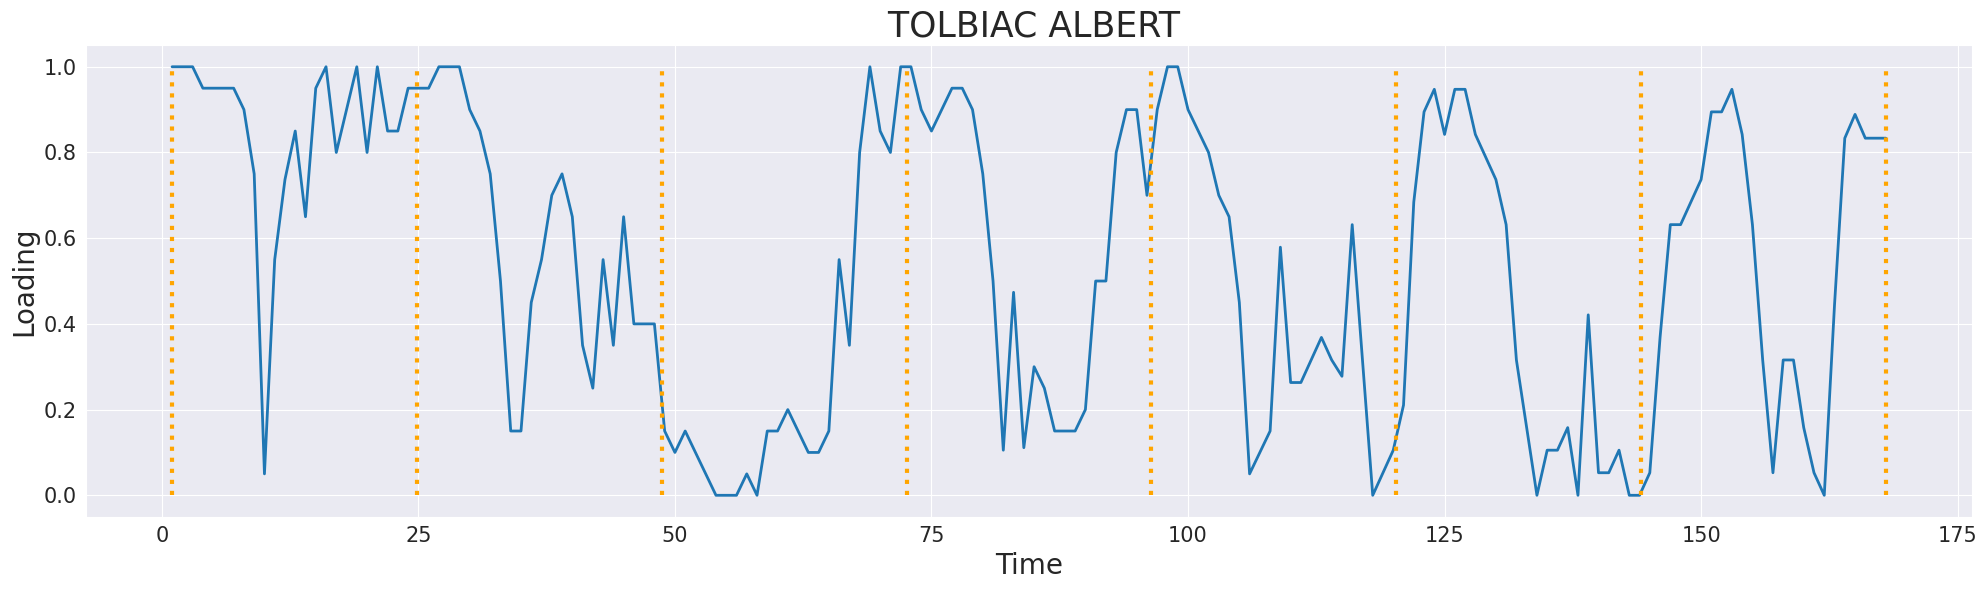

In [58]:
### TO BE COMPLETED ### 

i = rd.randrange(loading.shape[0])
loading_data = loading.to_numpy()


n_steps = loading.shape[1]  # number of observed time steps
time_range    = np.linspace(1,n_steps,n_steps)  # observed time range
time_tick  = np.linspace(1,n_steps,8)
# --- #

plt.figure(figsize = (20, 6))

plt.plot(time_range, loading_data[i,:], linewidth=2)
plt.vlines(x = time_tick, ymin = 0, ymax = 1, 
           colors = "orange", linestyle = "dotted", linewidth = 3)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.title(coord.names[1 + i], fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

In [56]:
# %load solutions/Python/plot_loading.py

> Comments?

##### <span style="color:purple"> **Question:** Does loading differ from one station to another?</span>

 Draw a matrix of plots of size 4*4 corresponding to 16 stations of your choice. _Do not forget the vertical lines corresponding to days_

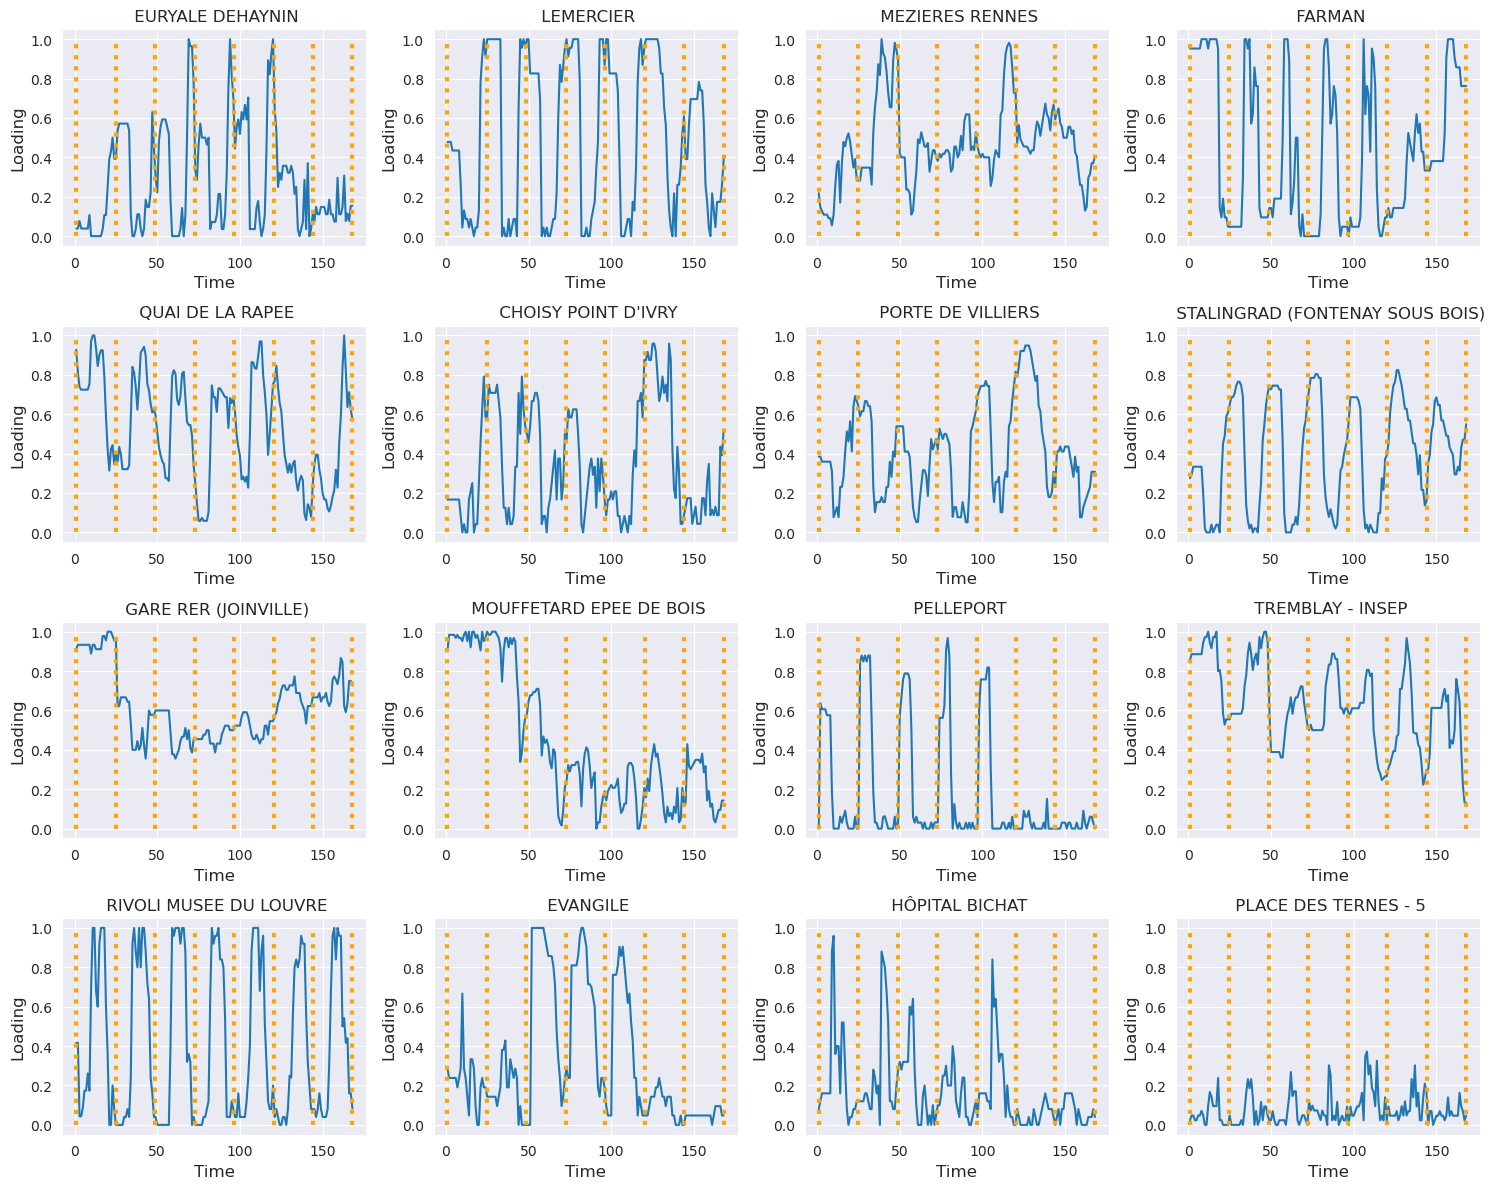

In [70]:
### TO BE COMPLETED ### 
stations=np.arange(loading.shape[0])
rd.shuffle(stations)
stations=stations[:16]
fig, axs = plt.subplots(4, 4, figsize = (15,12))
for i in range(4):
    for j in range(4):
        k_station=4*i+j
        axs[i,j].plot(time_range,loading_data[k_station,:])
        axs[i,j].vlines(x = time_tick, ymin = 0, ymax = 1, 
           colors = "orange", linestyle = "dotted", linewidth = 3)
        axs[i,j].set_title(coord.names[1 + k_station], fontsize = 12)
for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Loading', fontsize = 12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
plt.tight_layout()
plt.show()

In [ ]:
# %load solutions/Python/plot_loading_16.py

> Comments?

##### <span style="color:purple"> **Todo:** Draw the boxplot of the variables, sorted in time order.</span>

1. What can you say about the distribution of the variables? 
2. Position, dispersion, symmetry? 
3. Can you see a difference between days?

_Hint:_ To change the graphical properties of boxplots (for example, the thickness of the median), use the [`patch_artist = True`](https://python-charts.com/distribution/box-plot-matplotlib/) argument in the `plt.boxplot` function.

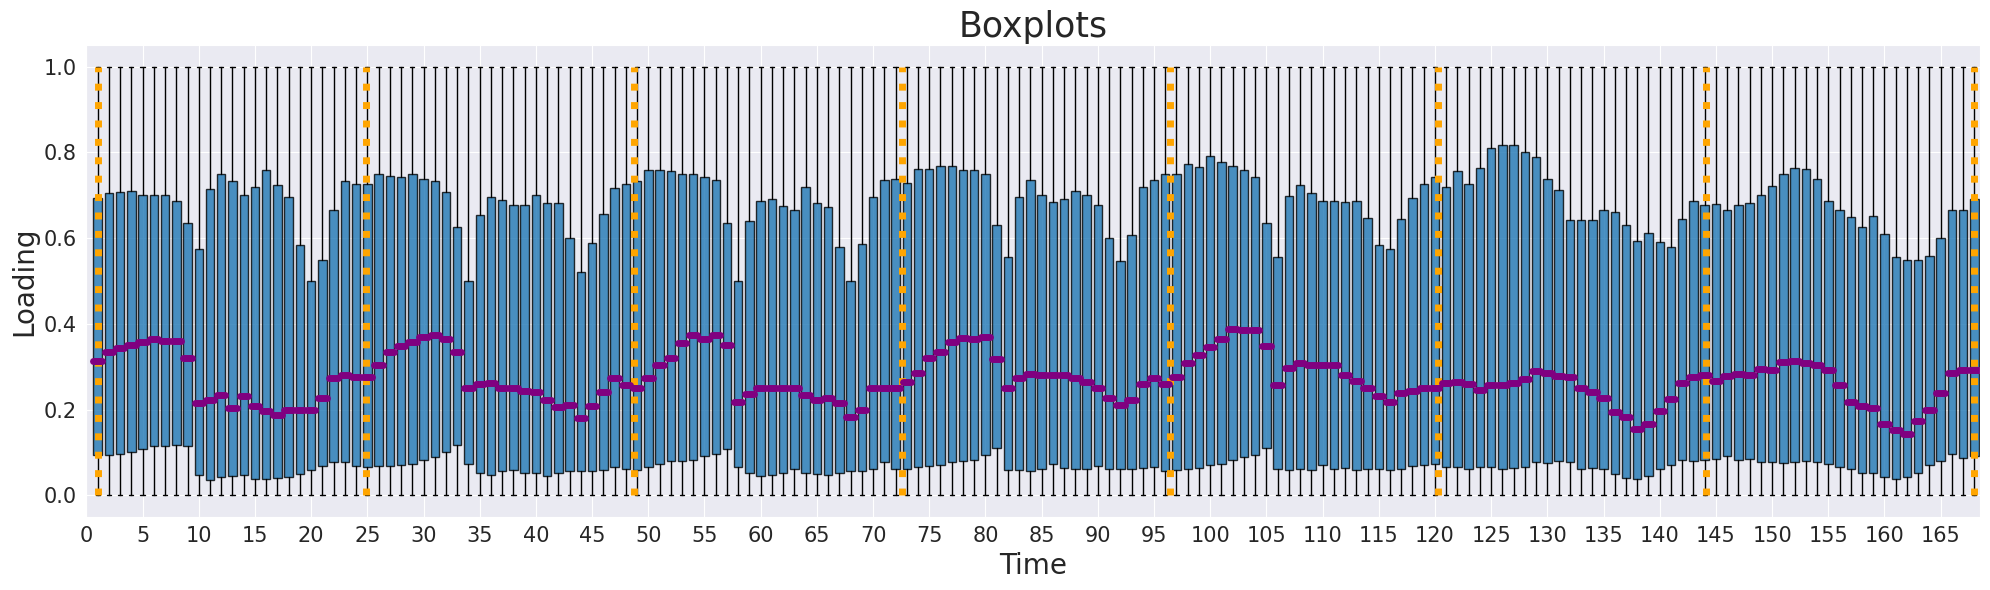

In [88]:
### TO BE COMPLETED ### 

plt.figure(figsize = (20,6))
bp = plt.boxplot(loading_data, widths = 0.75, patch_artist = True)

for box in bp['boxes']:
    box.set_alpha(0.8)  #chinh do trong suot
    
for median in bp['medians']:
    median.set(color = "Purple", linewidth=5)
    
plt.vlines(x = time_tick, ymin = 0, ymax = 1, 
           colors = "Orange", linestyle = "dotted", linewidth = 5)

plt.xlabel('Time', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.title("Boxplots", fontsize = 25)

plt.xticks(ticks = np.arange(0, 168, 5), labels=np.arange(0, 168, 5), fontsize = 15)
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.show()

In [ ]:
# %load solutions/Python/plot_loading_disp.py

> Comments?

## Average Loading

##### <span style="color:purple"> **Question:** What is the average station fill rate?</span>

Which station is, on average, the fullest? the least full?

In [96]:
### TO BE COMPLETED ### 

print('--- Average fill rate ---')
print(loading.mean().mean())

# --- #
print('')

loading_mean = pd.Series(loading.mean(axis=1))
print('--- Least crowded station, on average ---')
i=loading_mean.idxmin()
print('Average fill rate :',loading_mean[i])
print(coord.loc[i])


# --- #
print('')

print('--- Fullest station, on average ---')
i = pd.Series(loading.mean(axis=1)).idxmax()
print('Average fill rate :',loading.mean(axis=1)[i])
print(coord.loc[i])

--- Average fill rate ---
0.3816217759807477

--- Least crowded station, on average ---
Average fill rate : 0.016132842025699153
longitude              2.427934
latitude              48.873929
bonus                         1
names         HORNET (BAGNOLET)
Name: 997, dtype: object

--- Fullest station, on average ---
Average fill rate : 0.9193722943722953
longitude                          2.398262
latitude                           48.81466
bonus                                     0
names         INSURRECTION AOUT 1944 (IVRY)
Name: 1107, dtype: object


In [ ]:
# %load solutions/Python/loading_mean.py

##### <span style="color:purple"> **Question:** Does the average load vary from one station to another?</span>

- Show the evolution of the average load for each station. 
- On the same graph, plot the average loading for the entire data set.

In [ ]:
### TO BE COMPLETED ### 



In [ ]:
# %load solutions/Python/plot_mean_stations.py

> Comments?

##### <span style="color:purple"> **Question:** Does the average load vary over the course of a day?</span>

Plot the average hourly loading for each day (on a single graph).

In [ ]:
### TO BE COMPLETED ### 

[...]

In [ ]:
# %load solutions/Python/plot_mean_hours.py

> Comments?

## Velib Station Map

In [ ]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import plotly.express as px

##### <span style="color:purple"> **Question:** Where are the velib stations located?</span>

- Plot the stations coordinates on a 2D map (latitude _vs._ longitude)
- Use the average hourly loading as a color scale
- You can consider different times of day, for example 6am, 12pm, 11pm on Monday, or the average weekly load at 6am.
- You can consider different days at the same time, or the average load for each day.
- You can use the [`scatter_mapbox`](https://plotly.com/python/scattermapbox/) function of the [`plotly.express`](https://plotly.com/python/plotly-express/) to charge the map of Paris

In [ ]:
### TO BE COMPLETED ### 
## Simple 2D representation
# Monday at hour 6h, 12h, 23h

# Hours to be displayed
hours = ...

# --- #

[...]

In [ ]:
# %load solutions/Python/plot_loading_2D_monday.py

> Comments?

In [ ]:
### TO BE COMPLETED ### 
## Simple 2D representation
# Loading at 6pm, depending on the day of the week

[...]

In [ ]:
# %load solutions/Python/plot_loading_2D_18h.py

> Comments?

In [ ]:
### TO BE COMPLETED ### 
## Visualization on the Paris map

[...]

In [ ]:
# %load solutions/Python/plot_loading_map.py

> Comments?

## Influence of Altitude Difference on Station Loading

##### <span style="color:purple"> **Question:** Does Paris have many hilltop stations?</span>

- Compare the number of hilltop stations with the others.

In [ ]:
loading_hill = ...

[...]

In [ ]:
# %load solutions/Python/hilltop_stations.py

##### <span style="color:purple"> **Question:** Are hilltop stations more crowded than others?</span>

- Plot the stations coordinates on a 2D map (latitude _vs._ longitude), using a different color for stations which are located on a hill.
- Redo the initial study, but distinguish hilltop stations from others.

In [ ]:
### TO BE COMPLETED ### 
## Simple 2D representation

[...]

In [ ]:
# %load solutions/Python/hilltop_stations_2D.py

In [ ]:
### TO BE COMPLETED ### 
## Visualization on the Paris map

coord['hill'] = coord['bonus'].astype('category') # convert to categorical

[...]

In [ ]:
# %load solutions/Python/hilltop_stations_map.py